# DNN-SE for IEEE 118-bus system with different PMU locations: 12, 32, 39, 118


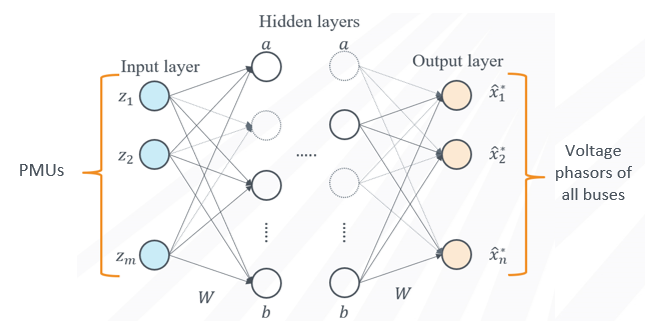

### 1. Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

import math
from scipy import stats
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import gradients
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras import regularizers
from sklearn.utils import shuffle
from tensorflow.keras import losses
import h5py
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from time import time 
np.random.seed(123)
tf.random.set_seed(123)

### 2. Import system configuration

In [2]:
#Import the branch information of the 118-bus system (the connectivity between buses)
branch_inf= pd.read_csv('branch_index_118bus.csv',header=None)
branch_inf= np.array(branch_inf)
print(f'There are {branch_inf.shape[0]} branches in IEEE 118-bus system')

There are 186 branches in IEEE 118-bus system


### 3. Define PMU locations and find indexes associated with these locations

In [3]:

# 12 pmus
pmu_list = [8,9,10,26,30,38,63,64,65,68,81,90] 
# 32 pmus
pmu_list = [1,5,10,12,13,17,21,25,28,34,37,41,45,49,53,56,62,64,72,73,75,77,80,85,87,91,94,101,105,110,114,116]
# 39 pmus
pmu_list = [3,5,8,9,10,12,15,17,21,24,26,28,30,35,38,40,43,46,50,52,56,62,63,64,65,68,73,75,77,80,81,85,87,91,94,102,105,110,114]
# 118 pmus
# pmu_list = list(np.arange(1,119)) 



# below, we're trying to find indexes associated with current values measured by PMUs as we're going to grab only information reported by PMU devices not the whole data.
# Note that we have both from-end and to-end current measurements and we should discriminate them.
for i in pmu_list:
    It=[] # to-end
    If=[] # from-end
    
    for j in range(branch_inf.shape[0]):
        
        if i == branch_inf[j,0]:
            If.append(j) 
        
        if i == branch_inf[j,1]:
            It.append(j)
    
    # Store mesurement indexes measured by each PMU separately (If_for_pmu8 includes mesurement indexes associated with from-end current measurements measured by PMU placed at bus 8)
    temp1 = "If_for_pmu"+str(i)
    temp2 = "It_for_pmu"+str(i)
    globals()[temp1] = If
    globals()[temp2] = It

In [5]:
len(pmu_list)

39

### 4. Define a function for noise modeling

In [6]:
# Build a 2-component non-Gaussian error model with the following configuration:
#Magnitude: Mu=[-0.004, 0.006] , Sigma=[0.0025 0.0025] , Weight = [0.4, 0.6]
#Angle : Mu = [-0.2, 0.3] , Sigma= [0.12, 0.12] , Weight = [0.4, 0.6]

def Varying_GMM_Error_vector_Creation(sample_size, Mu_vector, Sigma_vector, weight_vector): ## The GMM error 
    error = sample_size
    nsamp = sample_size
    data1 = stats.norm.rvs(loc=Mu_vector[0], scale=Sigma_vector[0], size=round(weight_vector[0]*sample_size)) 
    data1 = data1.reshape(-1, 1)
    data2 = stats.norm.rvs(loc=Mu_vector[1], scale=Sigma_vector[1], size=round(weight_vector[1]*sample_size)) 
    data2 = data2.reshape(-1, 1)
    GMM_vector = np.vstack((data1, data2)) 
    error = GMM_vector
    np.random.shuffle(error)
    return(error)

def NoisyAng(x):
    for i in range (x.shape[1]):
        y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.2, 0.3], [0.12, 0.12], [0.4, 0.6])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
        
    return x

def NoisyMag(x):
    for i in range (x.shape[1]):
        y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.004, 0.006], [0.0025, 0.0025], [0.4, 0.6])
#         y = 1+y #For Multiplicative error
#         x[:,i] = np.multiply(y, x[:,i].reshape(-1,1)).reshape(-1,) #Multiplicative error
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
## Multiplicative error is not suitable for values less than 1. But additive error is always workable.        
        
    return x

### In case you want to apply a Gaussian noise model instead of a non-Gaussian one

In [ ]:
# Build a Gaussian error model
#Magnitude: Mu=[0] , Sigma=[0.01/3]
#Angle : Mu = [0] , Sigma= [0.573/3]

def Gaussian_error(sample_size, Mu, Sigma):
    error = sample_size
    nsamp = sample_size
    data1 = stats.norm.rvs(loc=Mu, scale=Sigma, size=sample_size)
    data1 = data1.reshape(-1, 1)
    error = data1
    np.random.shuffle(error)
    return(error)

def NoisyAng(x):
    for i in range (x.shape[1]):
        y = Gaussian_error(x.shape[0], [0], [0.573/3])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error      
    return x

def NoisyMag(x):
    for i in range (x.shape[1]):
        y = Gaussian_error(x.shape[0], [0], [0.01/3])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
## Multiplicative error is not suitable for values less than 1. But additive error is always workable.        
        
    return x

### 5. Import V & I data (previously generated in MATLAB by a power flow solver)

In [ ]:
# filepath1 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\DATA with Increased Decimals\Train/'
# filepath2 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\DATA with Increased Decimals\Test/'

# # Training data
# If_mag = scipy.io.loadmat(filepath1 + 'If_mag_train_T1_12am.mat')['If_magT']
# If_ang = scipy.io.loadmat(filepath1 + 'If_ang_train_T1_12am.mat')['If_angT']
# It_mag= scipy.io.loadmat(filepath1 + 'It_mag_train_T1_12am.mat')['It_magT']
# It_ang = scipy.io.loadmat(filepath1 + 'It_ang_train_T1_12am.mat')['It_angT']
# V_mag = scipy.io.loadmat(filepath1 + 'VDATA_mag_train_T1_12am.mat')['VDATA_magT']
# V_ang = scipy.io.loadmat(filepath1 + 'VDATA_ang_train_T1_12am.mat')['VDATA_angT']

# # # Test data
# If_mag_test = scipy.io.loadmat(filepath2 + 'If_mag_test_T1_12am.mat')['If_magT']
# If_ang_test = scipy.io.loadmat(filepath2 + 'If_ang_test_T1_12am.mat')['If_angT']
# It_mag_test= scipy.io.loadmat(filepath2 + 'It_mag_test_T1_12am.mat')['It_magT']
# It_ang_test = scipy.io.loadmat(filepath2 + 'It_ang_test_T1_12am.mat')['It_angT']
# V_mag_test = scipy.io.loadmat(filepath2 + 'VDATA_mag_test_T1_12am.mat')['VDATA_magT']
# V_ang_test = scipy.io.loadmat(filepath2 + 'VDATA_ang_test_T1_12am.mat')['VDATA_angT']


In [7]:
filepath1 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\Train\Currents/' #File path to the training data-currents
filepath2 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\Train\Voltages/' #File path to the training data-voltages

filepath3 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\Test\Currents/' #File path to the test data-currents
filepath4 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\Test\Voltages/' #File path to the test data-voltages


# Training data
df_If_mag = pd.read_csv(filepath1+('If_mag_train_T1_12am.csv'), header = None)
df_If_ang = pd.read_csv(filepath1+('If_ang_train_T1_12am.csv'), header = None)
df_It_mag= pd.read_csv(filepath1+('It_mag_train_T1_12am.csv'), header = None)
df_It_ang = pd.read_csv(filepath1+('It_ang_train_T1_12am.csv'), header = None)
df_V_mag = pd.read_csv(filepath2+('VDATA_mag_train_T1_12am.csv'), header = None)
df_V_ang = pd.read_csv(filepath2+('VDATA_ang_train_T1_12am.csv'), header = None)

# Test data
df_If_mag_test = pd.read_csv(filepath3+('If_mag_test_T1_12am.csv'), header = None)
df_If_ang_test = pd.read_csv(filepath3+('If_ang_test_T1_12am.csv'), header = None)
df_It_mag_test= pd.read_csv(filepath3+('It_mag_test_T1_12am.csv'), header = None)
df_It_ang_test = pd.read_csv(filepath3+('It_ang_test_T1_12am.csv'), header = None)
df_V_mag_test = pd.read_csv(filepath4+('VDATA_mag_test_T1_12am.csv'), header = None)
df_V_ang_test = pd.read_csv(filepath4+('VDATA_ang_test_T1_12am.csv'), header = None)

### 6. Add noise to the imported data using that defined function

In [8]:
# Add noise to training data
If_mag_noisy = NoisyMag(np.array(df_If_mag))
If_ang_noisy = NoisyAng(np.array(df_If_ang))

It_mag_noisy = NoisyMag(np.array(df_It_mag))
It_ang_noisy = NoisyAng(np.array(df_It_ang))

V_mag_noisy = NoisyMag(np.array(df_V_mag))
V_ang_noisy = NoisyAng(np.array(df_V_ang))

In [9]:
# Add noise to test data
If_mag_noisy_test = NoisyMag(np.array(df_If_mag_test))
If_ang_noisy_test = NoisyAng(np.array(df_If_ang_test))

It_mag_noisy_test = NoisyMag(np.array(df_It_mag_test))
It_ang_noisy_test = NoisyAng(np.array(df_It_ang_test))

V_mag_noisy_test = NoisyMag(np.array(df_V_mag_test))
V_ang_noisy_test = NoisyAng(np.array(df_V_ang_test))


### 7. Create output data

In [11]:
# Output layer consists of actual voltage Mag & Ang for all the buses, so we need to concatenate them
y1_train = df_V_mag.to_numpy() #Mag
y2_train = df_V_ang.to_numpy() #Ang

y_train = np.concatenate((y1_train,y2_train) ,axis=1)
y_train.shape

(28000, 236)

In [12]:
# Create output layer for test data
y1_test = df_V_mag_test.to_numpy()
y2_test = df_V_ang_test.to_numpy()

y_test = np.concatenate((y1_test,y2_test) ,axis=1)
y_test.shape

(4000, 236)

### 8. Create input data
*  Use the identified indexes in Section 3 to grab information associated with PMUs for V & I

#### Training

In [13]:
counter = 0
for i in pmu_list:
    
    ###### Grab current Measurements ############
    
    ################## If ####################### 
    temp1= globals()["If_for_pmu"+str(i)]
    if bool(temp1):
        for j in temp1:
            globals()["d"+str(counter)] = If_mag_noisy[:,j]
            counter += 1
            globals()["d"+str(counter)] = If_ang_noisy[:,j]
            counter += 1
    pass

    ################## It #######################   
    temp2 = globals()["It_for_pmu"+str(i)]  
    if bool(temp2):
        for k in temp2:
            globals()["d"+str(counter)] = It_mag_noisy[:,k]
            counter += 1
            globals()["d"+str(counter)] = It_ang_noisy[:,k]
            counter += 1

            pass
        
    ###### Grab voltage Measurements ############
    globals()["d"+str(counter)] = V_ang_noisy[:,i-1]
    counter += 1
    globals()["d"+str(counter)] = V_mag_noisy[:,i-1]
    counter += 1

    
# Stack all data in a single matrix to define input data
whole_data = []
for m in range(0,counter):
    temp = globals()['d'+str(m)]
    whole_data.append(temp)

result = np.stack(whole_data, axis=0)

x_train = result.T

In [14]:
x_train.shape #82 features coming from PMUs

(28000, 348)

#### Test

In [15]:
counter = 0

for i in pmu_list:
    ###### Grab current Measurements ############
    ################## If ####################### 
    temp1= globals()["If_for_pmu"+str(i)]
    if bool(temp1):
        for j in temp1:
            globals()["d"+str(counter)] = If_mag_noisy_test[:,j]
            counter += 1
            globals()["d"+str(counter)] = If_ang_noisy_test[:,j]
            counter += 1
    pass

    ################## It #######################   
    temp2 = globals()["It_for_pmu"+str(i)]  
    if bool(temp2):
        for k in temp2:
            globals()["d"+str(counter)] = It_mag_noisy_test[:,k]
            counter += 1
            globals()["d"+str(counter)] = It_ang_noisy_test[:,k]
            counter += 1

            pass
    ###### Grab voltage Measurements ############
    globals()["d"+str(counter)] = V_ang_noisy_test[:,i-1]
    counter += 1
    globals()["d"+str(counter)] = V_mag_noisy_test[:,i-1]
    counter += 1

    

whole_data_test = []
for m in range(0,counter):
    temp = globals()['d'+str(m)]
    whole_data_test.append(temp)

result_test = np.stack(whole_data_test, axis=0)

x_test = result_test.T

In [16]:
x_test.shape

(4000, 348)

### 9. Normalization Process 

### 9.1. Min-Max Scaler

In [17]:
# We use min-max scaler to normalize data which scalesdat within 0~1

def normalize(x):
    
    x_min = np.amin(x)
    x_max = np.amax(x)
    x_norm = (x-x_min)/(x_max-x_min)
    
    return x_norm,x_min,x_max

In [18]:
#Normalizing Data based on the defined function
x_normalized_train = np.zeros(x_train.shape) 
y_normalized_train = np.zeros(y_train.shape)  
x_normalized_test = np.zeros(x_test.shape)
y_normalized_test = np.zeros(y_test.shape)  


for i in range(x_train.shape[1]):
    t1,x_min,x_max = normalize(x_train[:,i])
    x_normalized_train[:,i] = t1
    x_normalized_test[:,i] = (x_test[:,i]-x_min)/(x_max-x_min) #normalize test based on train
    

for j in range(y_train.shape[1]):
    t2,y_min,y_max = normalize(y_train[:,j])
    y_normalized_train[:,j] = t2
    y_normalized_test[:,j] = (y_test[:,j]-y_min)/(y_max-y_min)


# x_normalized_test = (x_test-x_min)/(x_max-x_min)
# y_normalized_test = (y_test-y_min)/(y_max-y_min)

C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_50392\3989276298.py:7: RuntimeWarning: invalid value encountered in divide
  x_norm = (x-x_min)/(x_max-x_min)
C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_50392\884511919.py:17: RuntimeWarning: invalid value encountered in divide
  y_normalized_test[:,j] = (y_test[:,j]-y_min)/(y_max-y_min)


### 9.2. Standrad Scaler
* If you have chosen Min-Max Scaler, skip this part

In [ ]:
# x_mu = x_train.mean(axis=0)
# x_std = x_train.std(axis=0)

# x_normalized_train = (x_train - x_mu)/x_std
# x_normalized_test= (x_test - x_mu)/x_std

# y_mu = y_train.mean(axis=0)
# y_std = y_train.std(axis=0)

# y_normalized_train = (y_train - y_mu)/y_std
# y_normalized_test= (y_test - y_mu)/y_std

In [ ]:
## If you want to see the distribution of normalized dat
# plt.hist(y_normalized_test[:,8])

### 9.3. Save the original data

In [19]:
# Save the original data to be able to convert them back to actual values after training and evaluation
main_y_train = y_train
main_x_train = x_train
main_y_test = y_test
main_x_test = x_test

### 10. Data cleaning (check NaNs)

In [22]:
max_x_train = np.amax(x_normalized_train)
min_x_train = np.amin(x_normalized_train)
max_x_test = np.amax(x_normalized_test)
min_x_test = np.amin(x_normalized_test)

max_y_train = np.amax(y_normalized_train)
min_y_train = np.amin(y_normalized_train)
max_y_test = np.amax(y_normalized_test)
min_y_test = np.amin(y_normalized_test)

print('max_x_train = ',max_x_train,'\n',
      'min_x_train = ',min_x_train,'\n',
      'max_x_test= ',max_x_test,'\n',
      'min_x_test',min_x_test,'\n',
      'max_y_train = ',max_y_train,'\n',
      'min_y_train = ',min_y_train,'\n',

      'max_y_test= ',max_y_test,'\n',
      'min_y_test',min_y_test,'\n',
     )

max_x_train =  1.0 
 min_x_train =  0.0 
 max_x_test=  1.5949374921625696 
 min_x_test -0.08662802607579645 
 max_y_train =  1.0 
 min_y_train =  0.0 
 max_y_test=  1.0666666666666584 
 min_y_test -0.12000000000000259 



###### Run the below cell in case there is any NaN or inf  in normalized data

In [21]:
y_normalized_train[np.isnan(y_normalized_train)] = 0
y_normalized_test[np.isnan(y_normalized_test)] = 0
x_normalized_train[np.isnan(x_normalized_train)] = 0
x_normalized_test[np.isnan(x_normalized_test)] = 0

### 11. Split data in train and validation

In [23]:
# split train and validation 
x_train, x_val, y_train, y_val = train_test_split(x_normalized_train, y_normalized_train, test_size=0.2)

x_test = x_normalized_test
y_test = y_normalized_test

### 12. Let's train the model (DNN-SE)

Epoch 1/1000
224/224 [==============================] - ETA: 0s - loss: 0.7481 - MSE: 0.7481
Epoch 1: val_loss improved from inf to 0.02132, saving model to weights.best.hdf5
224/224 [==============================] - 16s 56ms/step - loss: 0.7481 - MSE: 0.7481 - val_loss: 0.0213 - val_MSE: 0.0213 - lr: 0.0010
Epoch 2/1000
224/224 [==============================] - ETA: 0s - loss: 0.1214 - MSE: 0.1214
Epoch 2: val_loss improved from 0.02132 to 0.01303, saving model to weights.best.hdf5
224/224 [==============================] - 14s 63ms/step - loss: 0.1214 - MSE: 0.1214 - val_loss: 0.0130 - val_MSE: 0.0130 - lr: 0.0010
Epoch 3/1000
224/224 [==============================] - ETA: 0s - loss: 0.0429 - MSE: 0.0429
Epoch 3: val_loss improved from 0.01303 to 0.00965, saving model to weights.best.hdf5
224/224 [==============================] - 12s 54ms/step - loss: 0.0429 - MSE: 0.0429 - val_loss: 0.0097 - val_MSE: 0.0097 - lr: 0.0010
Epoch 4/1000
223/224 [============================>.] - ETA

Epoch 28/1000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 28: val_loss improved from 0.00329 to 0.00304, saving model to weights.best.hdf5
224/224 [==============================] - 18s 79ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 0.0010
Epoch 29/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 29: val_loss improved from 0.00304 to 0.00294, saving model to weights.best.hdf5
224/224 [==============================] - 15s 67ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 0.0010
Epoch 30/1000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 30: val_loss did not improve from 0.00294
224/224 [==============================] - 15s 67ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 0.0010
Epoch 31/1000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0

Epoch 55/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0028 - MSE: 0.0028
Epoch 55: val_loss improved from 0.00163 to 0.00159, saving model to weights.best.hdf5
224/224 [==============================] - 13s 60ms/step - loss: 0.0028 - MSE: 0.0028 - val_loss: 0.0016 - val_MSE: 0.0016 - lr: 0.0010
Epoch 56/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0027 - MSE: 0.0027
Epoch 56: val_loss improved from 0.00159 to 0.00156, saving model to weights.best.hdf5
224/224 [==============================] - 15s 66ms/step - loss: 0.0027 - MSE: 0.0027 - val_loss: 0.0016 - val_MSE: 0.0016 - lr: 0.0010
Epoch 57/1000
224/224 [==============================] - ETA: 0s - loss: 0.0027 - MSE: 0.0027
Epoch 57: val_loss did not improve from 0.00156
224/224 [==============================] - 15s 66ms/step - loss: 0.0027 - MSE: 0.0027 - val_loss: 0.0016 - val_MSE: 0.0016 - lr: 0.0010
Epoch 58/1000
224/224 [==============================] - ETA: 0s - loss: 0.0027 - MSE: 0

Epoch 83/1000
224/224 [==============================] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 83: val_loss did not improve from 0.00132
224/224 [==============================] - 9s 39ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 84/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 84: val_loss did not improve from 0.00132
224/224 [==============================] - 7s 33ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 85/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 85: val_loss did not improve from 0.00132
224/224 [==============================] - 8s 36ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 86/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 86: val_loss improved from 0.00132 to 0.00132, saving mod

Epoch 112/1000
224/224 [==============================] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 112: val_loss did not improve from 0.00131
224/224 [==============================] - 8s 34ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 113/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 113: val_loss improved from 0.00131 to 0.00131, saving model to weights.best.hdf5
224/224 [==============================] - 8s 37ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 114/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 114: val_loss did not improve from 0.00131
224/224 [==============================] - 7s 33ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 115/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 115: val_lo

Epoch 169/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 169: val_loss did not improve from 0.00129
224/224 [==============================] - 7s 33ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 170/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 170: val_loss did not improve from 0.00129
224/224 [==============================] - 7s 32ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 171/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 171: val_loss did not improve from 0.00129
224/224 [==============================] - 6s 28ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 172/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 172: val_loss did not improve from 0.00129
224/224

224/224 [==============================] - 7s 29ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 198/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 198: val_loss did not improve from 0.00128
224/224 [==============================] - 7s 32ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 199/1000
224/224 [==============================] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 199: val_loss did not improve from 0.00128
224/224 [==============================] - 7s 32ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 200/1000
224/224 [==============================] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 200: val_loss did not improve from 0.00128
224/224 [==============================] - 7s 31ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 201/10

223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 254: val_loss did not improve from 0.00126
224/224 [==============================] - 8s 35ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 255/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 255: val_loss did not improve from 0.00126
224/224 [==============================] - 8s 36ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 256/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 256: val_loss did not improve from 0.00126
224/224 [==============================] - 7s 32ms/step - loss: 0.0025 - MSE: 0.0025 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 257/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0025 - MSE: 0.0025
Epoch 257: val_loss did not improve from 0.00126
224/224 [=============

Epoch 283/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 283: val_loss improved from 0.00126 to 0.00126, saving model to weights.best.hdf5
224/224 [==============================] - 7s 33ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 284/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 284: val_loss did not improve from 0.00126
224/224 [==============================] - 8s 34ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 285/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 285: val_loss did not improve from 0.00126
224/224 [==============================] - 7s 32ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 286/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 286: val_lo

Epoch 312/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 312: val_loss did not improve from 0.00126
224/224 [==============================] - 9s 40ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 313/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 313: val_loss did not improve from 0.00126
224/224 [==============================] - 8s 38ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 314/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 314: val_loss did not improve from 0.00126
224/224 [==============================] - 10s 45ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 315/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 315: val_loss improved from 0.00126 to 0.00126, s

Epoch 341/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 341: val_loss did not improve from 0.00125
224/224 [==============================] - 7s 31ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 342/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 342: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 35ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 343/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 343: val_loss did not improve from 0.00125
224/224 [==============================] - 7s 32ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 344/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 344: val_loss improved from 0.00125 to 0.00125, sa

Epoch 370/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 370: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 35ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 371/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 371: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 37ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 372/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 372: val_loss did not improve from 0.00125
224/224 [==============================] - 6s 28ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 373/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 373: val_loss did not improve from 0.00125
224/224

Epoch 399/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 399: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 37ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 400/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 400: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 37ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 401/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 401: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 34ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 402/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 402: val_loss did not improve from 0.00125
224/224

Epoch 428/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 428: val_loss did not improve from 0.00125
224/224 [==============================] - 9s 39ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 429/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 429: val_loss did not improve from 0.00125
224/224 [==============================] - 7s 29ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 430/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 430: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 37ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 431/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 431: val_loss did not improve from 0.00125
224/224

Epoch 457/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 457: val_loss did not improve from 0.00125
224/224 [==============================] - 9s 38ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 458/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 458: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 35ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 459/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 459: val_loss did not improve from 0.00125
224/224 [==============================] - 8s 34ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 460/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 460: val_loss did not improve from 0.00125
224/224

Epoch 486/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 486: val_loss did not improve from 0.00124
224/224 [==============================] - 8s 36ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 487/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 487: val_loss did not improve from 0.00124
224/224 [==============================] - 10s 44ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 488/1000
222/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 488: val_loss did not improve from 0.00124
224/224 [==============================] - 7s 30ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 489/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 489: val_loss did not improve from 0.00124
224/22

Epoch 515/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 515: val_loss did not improve from 0.00124
224/224 [==============================] - 8s 38ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0013 - val_MSE: 0.0013 - lr: 1.0000e-04
Epoch 516/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 516: val_loss did not improve from 0.00124
224/224 [==============================] - 8s 38ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 517/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 517: val_loss did not improve from 0.00124
224/224 [==============================] - 9s 41ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 518/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 518: val_loss did not improve from 0.00124
224/224

Epoch 544/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 544: val_loss did not improve from 0.00123
224/224 [==============================] - 9s 41ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 545/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 545: val_loss improved from 0.00123 to 0.00123, saving model to weights.best.hdf5
224/224 [==============================] - 7s 33ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 546/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 546: val_loss did not improve from 0.00123
224/224 [==============================] - 8s 36ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 547/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 547: val_lo

Epoch 573/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 573: val_loss did not improve from 0.00123
224/224 [==============================] - 8s 37ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 574/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 574: val_loss did not improve from 0.00123
224/224 [==============================] - 10s 44ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 575/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 575: val_loss did not improve from 0.00123
224/224 [==============================] - 9s 39ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 576/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 576: val_loss did not improve from 0.00123
224/22

Epoch 602/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 602: val_loss did not improve from 0.00123
224/224 [==============================] - 8s 35ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 603/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 603: val_loss did not improve from 0.00123
224/224 [==============================] - 9s 42ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 604/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 604: val_loss did not improve from 0.00123
224/224 [==============================] - 8s 37ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 605/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 605: val_loss did not improve from 0.00123
224/224

Epoch 631/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 631: val_loss did not improve from 0.00122
224/224 [==============================] - 10s 43ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 632/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 632: val_loss did not improve from 0.00122
224/224 [==============================] - 8s 34ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 633/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 633: val_loss did not improve from 0.00122
224/224 [==============================] - 8s 34ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 634/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 634: val_loss did not improve from 0.00122
224/22

Epoch 660/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 660: val_loss did not improve from 0.00122
224/224 [==============================] - 9s 40ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 661/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 661: val_loss did not improve from 0.00122
224/224 [==============================] - 7s 33ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 662/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 662: val_loss did not improve from 0.00122
224/224 [==============================] - 9s 39ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 663/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 663: val_loss did not improve from 0.00122
224/224

Epoch 689/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 689: val_loss did not improve from 0.00122
224/224 [==============================] - 8s 37ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 690/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 690: val_loss did not improve from 0.00122
224/224 [==============================] - 10s 45ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 691/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 691: val_loss did not improve from 0.00122
224/224 [==============================] - 9s 39ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 692/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 692: val_loss improved from 0.00122 to 0.00122, s

224/224 [==============================] - 11s 47ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 718/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 718: val_loss did not improve from 0.00120
224/224 [==============================] - 16s 70ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 719/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 719: val_loss did not improve from 0.00120
224/224 [==============================] - 12s 51ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 720/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 720: val_loss did not improve from 0.00120
224/224 [==============================] - 8s 36ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 721

Epoch 775/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 775: val_loss did not improve from 0.00120
224/224 [==============================] - 11s 47ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 776/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 776: val_loss did not improve from 0.00120
224/224 [==============================] - 12s 52ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 777/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 777: val_loss did not improve from 0.00120
224/224 [==============================] - 12s 53ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 778/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 778: val_loss did not improve from 0.00120
224/

Epoch 804/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 804: val_loss did not improve from 0.00119
224/224 [==============================] - 11s 51ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 805/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 805: val_loss did not improve from 0.00119
224/224 [==============================] - 11s 48ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 806/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 806: val_loss did not improve from 0.00119
224/224 [==============================] - 12s 54ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 807/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 807: val_loss did not improve from 0.00119
224/

Epoch 833/1000
224/224 [==============================] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 833: val_loss did not improve from 0.00119
224/224 [==============================] - 13s 58ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 834/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 834: val_loss did not improve from 0.00119
224/224 [==============================] - 13s 57ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 835/1000
224/224 [==============================] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 835: val_loss did not improve from 0.00119
224/224 [==============================] - 14s 64ms/step - loss: 0.0024 - MSE: 0.0024 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 836/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0024 - MSE: 0.0024
Epoch 836: val_loss did not improve from 0.00119
224/

Epoch 862/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 862: val_loss did not improve from 0.00119
224/224 [==============================] - 12s 55ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 863/1000
224/224 [==============================] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 863: val_loss did not improve from 0.00119
224/224 [==============================] - 13s 58ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 864/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 864: val_loss did not improve from 0.00119
224/224 [==============================] - 11s 47ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 865/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 865: val_loss did not improve from 0.00119
224/

Epoch 891/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 891: val_loss did not improve from 0.00119
224/224 [==============================] - 13s 57ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 892/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 892: val_loss did not improve from 0.00119
224/224 [==============================] - 12s 55ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 893/1000
224/224 [==============================] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 893: val_loss did not improve from 0.00119
224/224 [==============================] - 12s 55ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 894/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 894: val_loss did not improve from 0.00119
224/

Epoch 920/1000
224/224 [==============================] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 920: val_loss improved from 0.00119 to 0.00118, saving model to weights.best.hdf5
224/224 [==============================] - 12s 54ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 921/1000
224/224 [==============================] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 921: val_loss did not improve from 0.00118
224/224 [==============================] - 14s 62ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 922/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 922: val_loss did not improve from 0.00118
224/224 [==============================] - 13s 58ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 923/1000
224/224 [==============================] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 923: val

224/224 [==============================] - 11s 51ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 949/1000
224/224 [==============================] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 949: val_loss did not improve from 0.00118
224/224 [==============================] - 13s 56ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 950/1000
224/224 [==============================] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 950: val_loss did not improve from 0.00118
224/224 [==============================] - 15s 67ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 951/1000
223/224 [============================>.] - ETA: 0s - loss: 0.0023 - MSE: 0.0023
Epoch 951: val_loss did not improve from 0.00118
224/224 [==============================] - 13s 57ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0012 - val_MSE: 0.0012 - lr: 1.0000e-04
Epoch 95

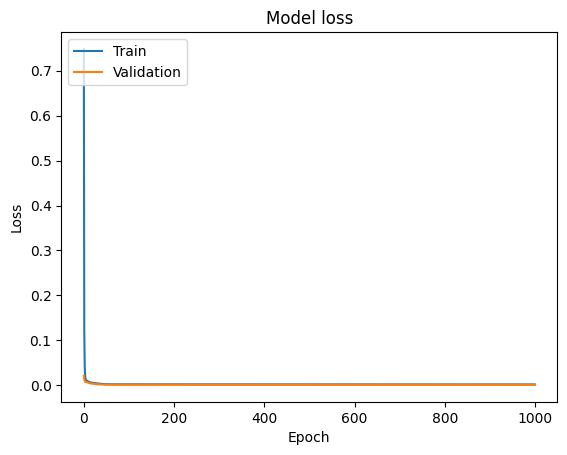

In [24]:
dp = 0.3 # set Dropout rate 
nu = 600 # number of neurons in each layer 
ne = 1000 # number of epochs

#################################### Model Architecture #############################################
model = Sequential()

model.add(Dense(nu, activation='relu', input_dim=x_train.shape[1], kernel_initializer='he_normal')) # Hidden 1
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 2
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 3
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 4
model.add(BatchNormalization())
model.add(Dropout(dp))

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 5
# model.add(BatchNormalization())
# model.add(Dropout(dp))

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 6

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 7



model.add(Dense(y_train.shape[1], activation='linear',kernel_initializer='he_normal')) # Output

################################## Model Configuration #####################################

# Adam(learning_rate=0.09456, beta_1=0.9, beta_2=0.999, amsgrad=False) # set configuration of Optimizer
# model.compile(loss='mean_absolute_error', metrics = ['mae'], optimizer='adam')
# reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.2,patience=10, min_lr=0.0001)
# filepath="weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True)


loss_fn = losses.MeanSquaredError() # set loss function 
Adam(learning_rate=0.09456, beta_1=0.9, beta_2=0.999, amsgrad=False) # set configuration of Optimizer
model.compile(loss=loss_fn, optimizer='adam', metrics=['MSE'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.0001)
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath,save_weights_only=True, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(x_train,y_train,verbose=1,epochs=ne , validation_data = (x_val,y_val),batch_size=100,callbacks=[checkpoint,reduce_lr])

# plot training history
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


### 13. Evaluate the model!

In [25]:
# Evaluation
start_SE = time()
pred = model.predict(x_test)
end_SE = time()
elapsed_time = end_SE - start_SE

# convert normalized data back to actual values before calculating MAE and MAPE
pred_actual = np.zeros(y_test.shape)
for j in range(main_y_train.shape[1]):
    t2,y_min,y_max = normalize(main_y_train[:,j])
    pred_actual[:,j] = (pred[:,j]*(y_max-y_min))+y_min
    

# pred_actual = pred*y_std + y_mu     ## When using standard scaler
    
# even_index = np.arange(0,y_test.shape[1],2)
# odd_index = np.arange(1,y_test.shape[1],2)

num_buses = df_V_mag.shape[1]
pred_mag_actual = pred_actual[:,0:num_buses] #first 2000 columns are related to mag
pred_ang_actual = pred_actual[:,-num_buses:]  #last 2000 columns are related to ang

phase_MAE = mean_absolute_error(pred_actual[:,-num_buses:], main_y_test[:,-num_buses:])
#Formulate MAPE by my own
mag_MAPE = np.sum(abs((main_y_test[:,0:num_buses]-pred_actual[:,0:num_buses])/main_y_test[:,0:num_buses]))/main_y_test[:,0:num_buses].shape[0]/(main_y_test[:,0:num_buses].shape[1])*100
#MAPE using the function (both give the same results)
mag_MAPE2 = mean_absolute_percentage_error(pred_actual[:,0:num_buses], main_y_test[:,0:num_buses])

print('MAE and MAPE Losses Based on Actual Data')
print(f'MAE_ang: {phase_MAE:.5f}, MAPE_mag: {mag_MAPE:.7f}')


125/125 [==============================] - 1s 7ms/step
MAE and MAPE Losses Based on Actual Data
MAE_ang: 0.10555, MAPE_mag: 0.0635333


C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_50392\3989276298.py:7: RuntimeWarning: invalid value encountered in divide
  x_norm = (x-x_min)/(x_max-x_min)
